In [1]:
!pip -q install nibabel pandas numpy matplotlib scikit-learn tqdm

In [2]:
import os, re, glob
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel


In [3]:
ATLAS_ROOT = r"D:\Kings_Spina\SpinaBifidaAtlas_v2"  # <-- change if needed

In [4]:
folders = sorted([p for p in glob.glob(os.path.join(ATLAS_ROOT, "*")) if os.path.isdir(p)])
folders[:5], len(folders)

(['D:\\Kings_Spina\\SpinaBifidaAtlas_v2\\fetal_SB_atlas_GA21_notoperated',
  'D:\\Kings_Spina\\SpinaBifidaAtlas_v2\\fetal_SB_atlas_GA22_notoperated',
  'D:\\Kings_Spina\\SpinaBifidaAtlas_v2\\fetal_SB_atlas_GA23_notoperated',
  'D:\\Kings_Spina\\SpinaBifidaAtlas_v2\\fetal_SB_atlas_GA24_notoperated',
  'D:\\Kings_Spina\\SpinaBifidaAtlas_v2\\fetal_SB_atlas_GA25_notoperated'],
 15)

In [5]:
def parse_ga_and_group(folder_name: str):
    """
    Extract GA (e.g., 21) and group ('operated'/'notoperated') from folder name.
    """
    m = re.search(r"GA(\d+)", folder_name)
    ga = int(m.group(1)) if m else None
    
    group = None
    if "notoperated" in folder_name.lower():
        group = "notoperated"
    elif "operated" in folder_name.lower():
        group = "operated"
    else:
        group = "unknown"
        
    return ga, group

def voxel_volume_mm3(nii):
    zooms = nii.header.get_zooms()[:3]
    return float(zooms[0] * zooms[1] * zooms[2])

def load_nifti(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return nii, data

def extract_tissue_volumes(folder_path: str):
    """
    Reads parcellation and optional mask, returns dict of volumes and proportions.
    Assumes label 0 = background; labels 1..N = tissue classes.
    """
    base = os.path.basename(folder_path)
    ga, group = parse_ga_and_group(base)
    
    parc_path = os.path.join(folder_path, "parcellation.nii.gz")
    mask_path = os.path.join(folder_path, "mask.nii.gz")
    
    if not os.path.exists(parc_path):
        raise FileNotFoundError(f"Missing parcellation: {parc_path}")
    
    parc_nii, parc = load_nifti(parc_path)
    parc = parc.astype(np.int32)
    vmm3 = voxel_volume_mm3(parc_nii)
    
    # apply brain mask if available
    if os.path.exists(mask_path):
        _, mask = load_nifti(mask_path)
        mask = mask > 0
        parc = np.where(mask, parc, 0)
    
    labels = np.unique(parc)
    labels = labels[labels != 0]
    
    brain_vox = int(np.sum(parc != 0))
    brain_vol = brain_vox * vmm3
    
    row = {
        "folder": base,
        "GA": ga,
        "group": group,
        "voxel_mm3": vmm3,
        "brain_volume_mm3": brain_vol,
        "n_labels": int(len(labels)),
    }
    
    for lab in labels:
        count = int(np.sum(parc == lab))
        row[f"tissue_{lab}_mm3"] = count * vmm3
        row[f"tissue_{lab}_prop"] = (count / brain_vox) if brain_vox > 0 else np.nan
    
    return row


In [6]:
rows = []
for f in tqdm(folders, desc="Extracting"):
    rows.append(extract_tissue_volumes(f))

df = pd.DataFrame(rows).sort_values(["GA", "group"]).reset_index(drop=True)
df.head()


Extracting: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.11it/s]


,folder,GA,group,voxel_mm3,brain_volume_mm3,n_labels,tissue_1_mm3,tissue_1_prop,tissue_2_mm3,tissue_2_prop,...,tissue_4_mm3,tissue_4_prop,tissue_5_mm3,tissue_5_prop,tissue_6_mm3,tissue_6_prop,tissue_7_mm3,tissue_7_prop,tissue_8_mm3,tissue_8_prop
0,fetal_SB_atlas_GA21_notoperated,21,notoperated,0.511998,51978.042784,8,28731.794985,0.552768,8402.400119,0.161653,...,1359.866840,0.026162,6173.160578,0.118765,4137.456302,0.079600,1647.097751,0.031688,237.055101,0.004561
1,fetal_SB_atlas_GA22_notoperated,22,notoperated,0.511998,61190.423830,8,32928.131063,0.538126,9968.602177,0.162911,...,2174.455750,0.035536,7715.810724,0.126095,4722.158083,0.077172,1719.289477,0.028097,340.990706,0.005573
2,fetal_SB_atlas_GA23_notoperated,23,notoperated,0.511998,71565.040466,8,38226.798959,0.534155,13552.588578,0.189374,...,2545.142343,0.035564,8454.111923,0.118132,4819.437714,0.067343,1693.177576,0.023659,361.982627,0.005058
3,fetal_SB_atlas_GA24_notoperated,24,notoperated,0.511998,85113.533060,8,42891.101262,0.503928,17895.356101,0.210253,...,5352.939690,0.062892,9853.914612,0.115774,5570.538864,0.065448,1784.825228,0.020970,418.302413,0.004915
4,fetal_SB_atlas_GA25_notoperated,25,notoperated,0.511998,95788.180558,8,47349.068347,0.494310,21381.550874,0.223217,...,4087.792490,0.042675,12259.281486,0.127983,6362.087861,0.066418,2062.328175,0.021530,462.846244,0.004832


In [7]:
df[["folder","GA","group","brain_volume_mm3","n_labels"]]

,folder,GA,group,brain_volume_mm3,n_labels
0,fetal_SB_atlas_GA21_notoperated,21,notoperated,51978.042784,8
1,fetal_SB_atlas_GA22_notoperated,22,notoperated,61190.423830,8
2,fetal_SB_atlas_GA23_notoperated,23,notoperated,71565.040466,8
3,fetal_SB_atlas_GA24_notoperated,24,notoperated,85113.533060,8
4,fetal_SB_atlas_GA25_notoperated,25,notoperated,95788.180558,8
5,fetal_SB_atlas_GA25_operated,25,operated,116996.164091,8
6,fetal_SB_atlas_GA26_operated,26,operated,147555.792140,8
7,fetal_SB_atlas_GA27_operated,27,operated,172826.992256,8
8,fetal_SB_atlas_GA28_operated,28,operated,168103.298179,8
9,fetal_SB_atlas_GA29_operated,29,operated,270120.959101,8


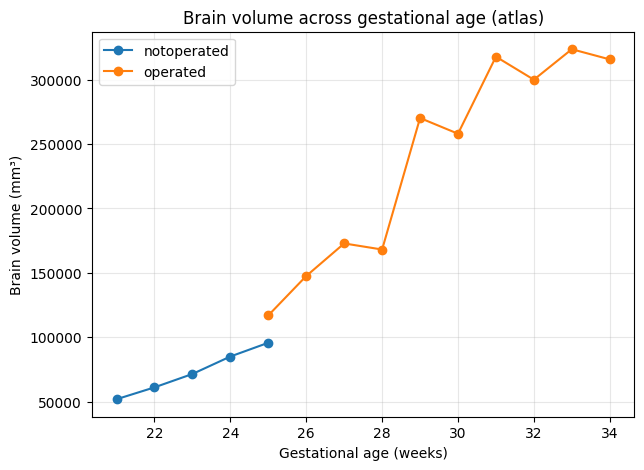

In [8]:
plt.figure(figsize=(7,5))
for grp in sorted(df["group"].unique()):
    sub = df[df["group"] == grp].sort_values("GA")
    plt.plot(sub["GA"], sub["brain_volume_mm3"], marker="o", label=grp)

plt.xlabel("Gestational age (weeks)")
plt.ylabel("Brain volume (mm³)")
plt.title("Brain volume across gestational age (atlas)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
ref = df[df["group"] == "notoperated"].dropna(subset=["GA","brain_volume_mm3"]).copy()
x = ref["GA"].values.reshape(-1,1).astype(float)
y = ref["brain_volume_mm3"].values.astype(float)

kernel = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=3.0, length_scale_bounds=(1e-1, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e-1))
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr.fit(x, y)

x_grid = np.linspace(df["GA"].min(), df["GA"].max(), 200).reshape(-1,1)
mu, std = gpr.predict(x_grid, return_std=True)


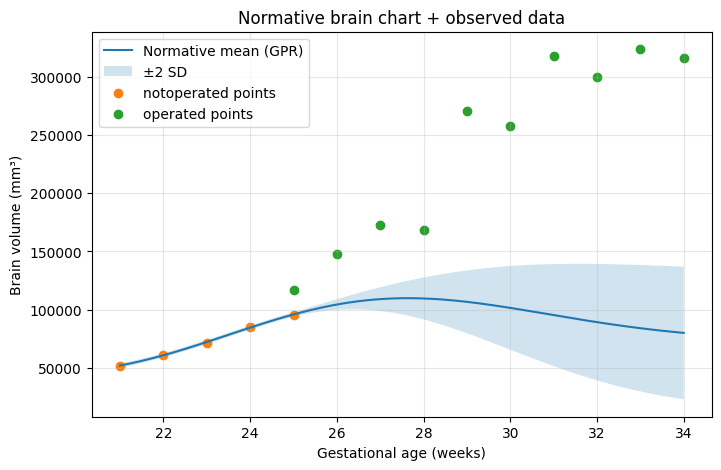

In [10]:
plt.figure(figsize=(8,5))

# normative curve
plt.plot(x_grid.ravel(), mu, label="Normative mean (GPR)")
plt.fill_between(x_grid.ravel(), mu-2*std, mu+2*std, alpha=0.2, label="±2 SD")

# data points
for grp in sorted(df["group"].unique()):
    sub = df[df["group"] == grp].sort_values("GA")
    plt.scatter(sub["GA"], sub["brain_volume_mm3"], label=f"{grp} points")

plt.xlabel("Gestational age (weeks)")
plt.ylabel("Brain volume (mm³)")
plt.title("Normative brain chart + observed data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
x_all = df["GA"].values.reshape(-1,1).astype(float)
pred_mu, pred_std = gpr.predict(x_all, return_std=True)
df["norm_mu_mm3"] = pred_mu
df["norm_std_mm3"] = pred_std
df["z_brain_volume"] = (df["brain_volume_mm3"] - df["norm_mu_mm3"]) / (df["norm_std_mm3"] + 1e-8)

df[["folder","GA","group","brain_volume_mm3","z_brain_volume"]]


,folder,GA,group,brain_volume_mm3,z_brain_volume
0,fetal_SB_atlas_GA21_notoperated,21,notoperated,51978.042784,-0.078327
1,fetal_SB_atlas_GA22_notoperated,22,notoperated,61190.423830,0.382518
2,fetal_SB_atlas_GA23_notoperated,23,notoperated,71565.040466,-0.771402
3,fetal_SB_atlas_GA24_notoperated,24,notoperated,85113.533060,0.591058
4,fetal_SB_atlas_GA25_notoperated,25,notoperated,95788.180558,-0.103535
5,fetal_SB_atlas_GA25_operated,25,operated,116996.164091,21.124482
6,fetal_SB_atlas_GA26_operated,26,operated,147555.792140,18.849028
7,fetal_SB_atlas_GA27_operated,27,operated,172826.992256,12.535734
8,fetal_SB_atlas_GA28_operated,28,operated,168103.298179,6.504386
9,fetal_SB_atlas_GA29_operated,29,operated,270120.959101,12.120999


In [12]:
tissue_mm3_cols = [c for c in df.columns if c.startswith("tissue_") and c.endswith("_mm3")]
tissue_mm3_cols


['tissue_1_mm3',
 'tissue_2_mm3',
 'tissue_3_mm3',
 'tissue_4_mm3',
 'tissue_5_mm3',
 'tissue_6_mm3',
 'tissue_7_mm3',
 'tissue_8_mm3']

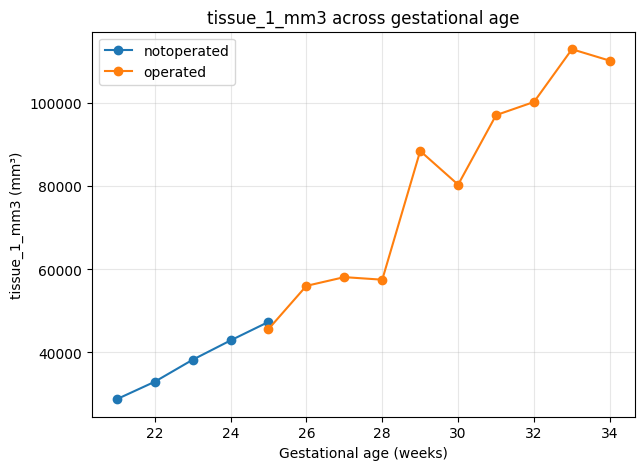

In [13]:
tcol = tissue_mm3_cols[0]  # change to tissue_1_mm3 etc.
plt.figure(figsize=(7,5))
for grp in sorted(df["group"].unique()):
    sub = df[df["group"] == grp].sort_values("GA")
    plt.plot(sub["GA"], sub[tcol], marker="o", label=grp)
plt.xlabel("Gestational age (weeks)")
plt.ylabel(f"{tcol} (mm³)")
plt.title(f"{tcol} across gestational age")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [14]:
import os

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

csv_path = os.path.join(OUTPUT_DIR, "atlas_tissue_volumes.csv")
df.to_csv(csv_path, index=False)

print("Saved CSV to:", os.path.abspath(csv_path))


Saved CSV to: D:\Neuroscience Home projects\fetal-brain-normative-charts\outputs\atlas_tissue_volumes.csv


In [15]:
import os
os.makedirs("figures", exist_ok=True)


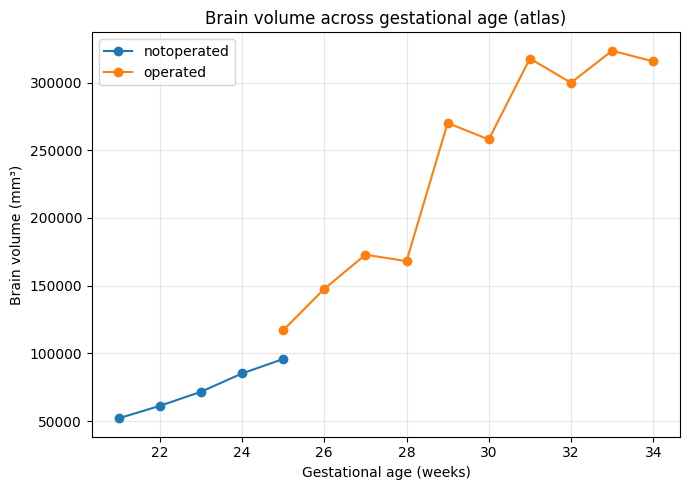

In [16]:
plt.figure(figsize=(7,5))
for grp in sorted(df["group"].unique()):
    sub = df[df["group"] == grp].sort_values("GA")
    plt.plot(sub["GA"], sub["brain_volume_mm3"], marker="o", label=grp)

plt.xlabel("Gestational age (weeks)")
plt.ylabel("Brain volume (mm³)")
plt.title("Brain volume across gestational age (atlas)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/brain_volume_across_GA.png", dpi=200)
plt.show()


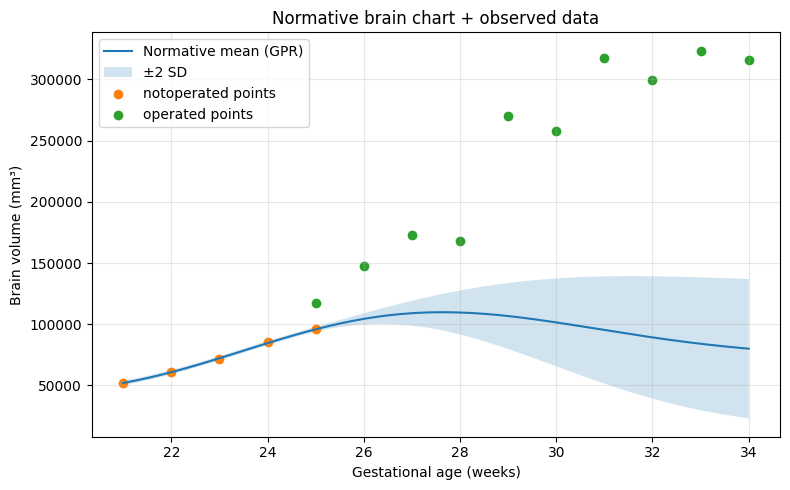

In [17]:
plt.figure(figsize=(8,5))

plt.plot(x_grid.ravel(), mu, label="Normative mean (GPR)")
plt.fill_between(x_grid.ravel(), mu-2*std, mu+2*std, alpha=0.2, label="±2 SD")

for grp in sorted(df["group"].unique()):
    sub = df[df["group"] == grp].sort_values("GA")
    plt.scatter(sub["GA"], sub["brain_volume_mm3"], label=f"{grp} points")

plt.xlabel("Gestational age (weeks)")
plt.ylabel("Brain volume (mm³)")
plt.title("Normative brain chart + observed data")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("figures/normative_brain_chart.png", dpi=200)
plt.show()


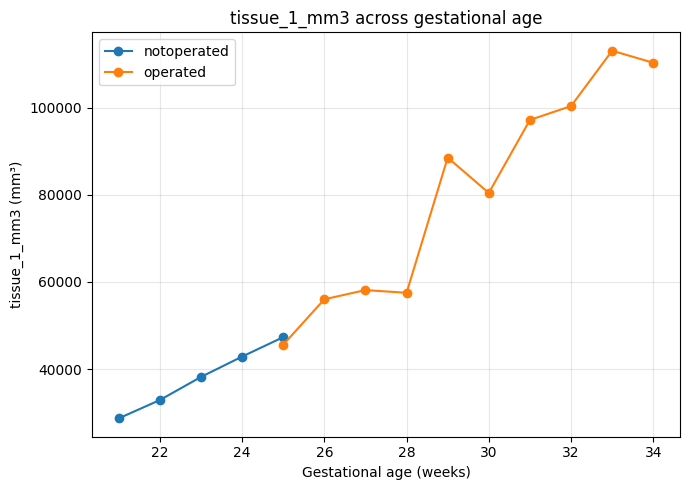

In [18]:
tcol = "tissue_1_mm3"

plt.figure(figsize=(7,5))
for grp in sorted(df["group"].unique()):
    sub = df[df["group"] == grp].sort_values("GA")
    plt.plot(sub["GA"], sub[tcol], marker="o", label=grp)

plt.xlabel("Gestational age (weeks)")
plt.ylabel(f"{tcol} (mm³)")
plt.title(f"{tcol} across gestational age")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"figures/{tcol}_across_GA.png", dpi=200)
plt.show()
